<a href="https://colab.research.google.com/github/isaashka/NLPMedicalAnalyzer/blob/main/NLPMedicalAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Analyzer

# Imports 

In [1]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

2024-06-09 15:04:23.060 Python[27475:135143] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
# General imports
import os
import numpy as np
import nltk
import pandas as pd
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/sasha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sasha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Model specific imports
from decimal import Decimal
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.util import ngrams
import math

from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt

# Data Preprocessing
### Goal: convert user input --> symptoms

In [43]:
# load the dataset
symptoms_dataset = pd.read_csv("Dataset/dis_sym_dataset_comb.csv")

# extract features to use as a symptom array
X = symptoms_dataset.iloc[:, 1:]
dataset_symptoms = list(X.columns)
# dataset_symptoms

### Normalizing User Input

In [44]:
import contractions
import re
from spellchecker import SpellChecker

In [92]:
def user_input():
    print("Enter symptoms: ")
    user_input = input()
    return normalize_user_input(user_input)

def correct_spelling(user_input):
    spell = SpellChecker()
    words = user_input.split()
    corrected_words = [spell.correction(word) for word in words]
    return ' '.join(corrected_words)

def normalize_user_input(user_input):
    # lowercase
    normalized_input = user_input.lower()
    # fix contractions
    normalized_input = contractions.fix(normalized_input)
    # get rid of punctuation
    normalized_input = re.sub(r'[^\w\s]', '', normalized_input)

    normalized_input = correct_spelling(normalized_input)
    # print(normalized_input)
    return(normalized_input)

In [93]:
user_symptoms = user_input()
user_symptoms

Enter symptoms: 


 I have been having migraines and headaches. I can't sleep. My whole body is shaking and shivering. I feel dizzy sometimes


'i have been having migraines and headaches i cannot sleep my whole body is shaking and shivering i feel dizzy sometimes'

### Ngram approach


Test input: I have been having migraines and headaches. I can't sleep. My whole body is shaking and shivering. I feel dizzy sometimes

In [7]:
def find_symptom_phrases(tokens, symptom_keywords, body_parts, n=2):
    symptom_phrases = []
    ngrams_list = list(ngrams(tokens, n))

    for ngram in ngrams_list:
        for keyword in symptom_keywords:
            for body_part in body_parts:
                if keyword in ngram and body_part in ngram:
                    symptom_phrases.append(' '.join(ngram))

    return symptom_phrases

# Lemmatize input
def lemmatize_tokens(tokens):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_tokens = []  
    for token in tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(token))
    return lemmatized_tokens

def tokenize_user_symptoms():
    print("Enter symptoms: ")
    
    symptoms = input()
    # tokenize input
    symptom_tokens = word_tokenize(symptoms)

    # lemmatize input
    symptom_tokens_lemmatized = lemmatize_tokens(symptom_tokens)

    # find symptom phrases using n-grams
    symptom_phrases = find_symptom_phrases(symptom_tokens_lemmatized, \
                                           dataset_symptoms, dataset_symptoms) # dataset_symptoms = symptoms retrieved from the dataset
    
    return symptom_phrases

In [8]:
extracted_symptoms = tokenize_user_symptoms()
print()
print('Here\'s your list of symptoms: ')
print(extracted_symptoms)

Enter symptoms: 


 I have been having migraines and headaches. I can't sleep. My whole body is shaking and shivering. I feel dizzy



Here's your list of symptoms: 
['and headache', 'headache .', 'is shaking', 'shaking and', 'and shivering', 'shivering .']


### NER approach 

In [46]:
# Import the necessary libraries
# !pip install transformers pandas nltk
from transformers import pipeline

In [49]:
# Load a pre-trained NER model that's specialized for biomedical text
ner = pipeline("ner", model="d4data/biomedical-ner-all")

# Load the symptoms dataset
symptoms_dataset = pd.read_csv("Dataset/dis_sym_dataset_comb.csv")

def extract_symptoms(text):
    # Use the NER pipeline to extract entities
    entities = ner(text)
    
    # Extract symptom-related entities detected by the model
    symptoms = [entity['word'] for entity in entities if 'symptom' in entity['entity'].lower()]
    
    # Tokenize the text for manual matching
    tokens = word_tokenize(text.lower())
    
    # Add manually matched symptoms from the dataset
    for token in tokens:
        if token in dataset_symptoms and token not in symptoms:
            symptoms.append(token)
    
    return symptoms

# Function to clean and join tokens into keywords
def clean_keywords(keywords):
    clean_tokens = []
    for token in keywords:
        if token.startswith("##"):
            clean_tokens[-1] = clean_tokens[-1] + token[2:]
        else:
            clean_tokens.append(token)
    return clean_tokens

In [51]:
# Example user input
user_input = "I have been having migraines and headaches. I can't sleep. My whole body is shaking and shivering. I feel dizzy sometimes. I have a fever."
new_user_input = normalize_user_input(user_input)

# Extract symptoms
symptoms = extract_symptoms(new_user_input)

# Clean and join the tokens into keywords
keywords = clean_keywords(symptoms)

# Display the symptoms
print("Extracted Symptoms:", symptoms)
print("Keywords:", keywords)

Extracted Symptoms: ['mig', '##raine', 'headache', 'cannot', 'sleep', 'shaking', 'shivering', 'dizzy', 'fever']
Keywords: ['migraine', 'headache', 'cannot', 'sleep', 'shaking', 'shivering', 'dizzy', 'fever']


#### Expand list of symptoms by finding synonyms

In [52]:
# find synonyms for extracted keywords
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /Users/sasha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
# Get synonyms of a list of words
def get_synonyms(words):
    synonyms = set()
    for word in words:
        # Get synsets (sets of synonyms) for each word
        synsets = wordnet.synsets(word)
        for synset in synsets:
            # Add synonyms of the word from each synset to the set
            synonyms.update([lemma.name() for lemma in synset.lemmas()])
    return synonyms

In [74]:
synonyms = get_synonyms(keywords)
print("Synonym set: ")
print(synonyms)
print()

print("List of all symptoms: ")
final_symptoms = list(synonyms)
print(final_symptoms)

Synonym set: 
{'throw_off', 'migraine', 'kip', 'shake_off', 'judder', 'lightheaded', 'headache', 'hemicrania', 'sleep', 'sick_headache', 'sway', 'head_ache', 'light-headed', 'megrim', 'didder', 'quivering', 'dizzy', 'quiver', 'fever', 'cephalalgia', 'escape_from', 'silly', 'throb', 'woozy', 'palpitation', 'vexation', "catch_some_Z's", 'trembling', 'rest', 'eternal_rest', 'shake_up', 'febrility', 'chill', 'empty-headed', 'stimulate', 'vertiginous', 'eternal_sleep', 'shakiness', 'nap', 'featherbrained', 'pyrexia', 'shaking', 'giddy', 'shudder', 'rock', 'quietus', 'shivering', 'airheaded', 'stir', 'thrill', 'sopor', 'febricity', 'concern', 'agitate', 'shaky', 'excite', 'shiver', "log_Z's", 'worry', 'vibration', 'slumber', 'shake', 'feverishness'}

List of all symptoms: 
['throw_off', 'migraine', 'kip', 'shake_off', 'judder', 'lightheaded', 'headache', 'hemicrania', 'sleep', 'sick_headache', 'sway', 'head_ache', 'light-headed', 'megrim', 'didder', 'quivering', 'dizzy', 'quiver', 'fever', '

In [76]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 566.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:0000:0100:01


In [124]:
def extract_relevant_symptoms(final_symptoms):
    syms_in_dataset = []
    for sym in final_symptoms:
        if sym in dataset_symptoms:
            syms_in_dataset.append(sym)
            # print(sym)
    return syms_in_dataset
    

In [125]:
extract_relevant_symptoms(final_symptoms)

['headache', 'fever', 'chill', 'shakiness', 'shaking', 'shivering']

## Possible future implementations for Preprocessing:

Look for symptom phrases to develop / inference a more descriptive symptom. Some keywords may not mean much on their own, but the words around them give more meaning. For example the word "sleep," the complete phrase may be "I can't sleep" or "I have trouble sleeping." To get the full picture we can look at words preceding and following the symptom keyword. 

_ _ _ sleep

sleep _ _ _


#### Getting different forms of the symptom keywords

We can increase chances of finding the right symptoms just by changing the form of the word used. Ex. "sleepy" to "sleepiness". But there are currently no libraries that can do this accurately and coding this up would take a lot of time which is beyond the scope of this project.

In [75]:
# Get all forms of the extracted symptoms
# i.e. 'sleep' --> 'sleepy', 'sleepiness', 'sleep'
#
# !pip install reversestem

from reversestem import unstem

unstem('sleep')

['sleepe',
 'sleeped',
 'sleepes',
 'sleeping',
 'sleepful',
 'sleepness',
 'sleepfulness']

# Models

Classification models used to match an input list of symptoms to the disease.

Following code inspired by this github repo: https://github.com/rahul15197/Disease-Detection-based-on-Symptoms?source=post_page-----54e6be60a3d1--------------------------------

We used the dataset from the github repo as well as some general structure of code. Most of the code was written by us to suit our overall structure.


In [135]:
# lists used for performance plots

model_list = []
f1_scores = []
accuracies = []

### Dataset

In [136]:
# load the dataset
symptoms_dataset = pd.read_csv("Dataset/dis_sym_dataset_comb.csv")

# separate the features and labels
X = symptoms_dataset.iloc[:, 1:]
Y = symptoms_dataset.iloc[:, 0:1]

# convert Y (labels) to a 1D array 
y_array = Y.to_numpy() if isinstance(Y, pd.Series) else Y.values
Y = y_array.ravel()

In [137]:
# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10)     

### Evaluate the Model

In [138]:
# fit model according to its type and make predictions
def fit_and_predict(classifier, model_type):
    classifier = classifier.fit(X, Y)

    # Predict on the test set
    y_pred = classifier.predict(x_test)
    
    precision, recall, f1, accuracy = evaluate_model(y_test, y_pred, model_type)
    print_evaluation_metrics(precision, recall, f1, accuracy)

# Evaluate the model on different metrics
def evaluate_model(y_test, y_pred, model_type):
    # Calculate precision, recall, and F1-score for each class and then compute the macro average
    precision = round(Decimal(precision_score(y_test, y_pred, average='macro', zero_division=1) * 100), 2)
    recall= round(Decimal(recall_score(y_test, y_pred, average='macro', zero_division=1) * 100), 2)
    f1= round(Decimal(f1_score(y_test, y_pred, average='macro') * 100), 2)
    
    # calculate accuracy
    accuracy = round(Decimal(accuracy_score(y_test, y_pred) * 100), 2)
    
    # Add metrics to overall arrays used later for graphing
    model_list.append(model_type)
    f1_scores.append(f1)
    accuracies.append(accuracy)

    return precision, recall, f1, accuracy
    
def print_evaluation_metrics(precision, recall, f1, accuracy):
    print(f'Macro-average Precision: {precision}%')
    print(f'Macro-average Recall: {recall}%')
    print(f'Macro-average F1-score: {f1}%')
    print(f'Accuracy: {accuracy}%')


In [139]:
# prints all model names and their f1 score and accuracy
def print_all_metrics():
    for i in range(len(model_list)):
        print(f'Model: {model_list[i]}, f1 = {f1_scores[i]} accuracy = {accuracies[i]}')
        # print(model_list[i], f1_scores[i], accuracies[i])

### Multinomial Naive Bayes

In [140]:
# Train the Naive Bayes classifier
mnb = MultinomialNB()
fit_and_predict(mnb, 'MultinomialNaiveBayes')

Macro-average Precision: 94.62%
Macro-average Recall: 56.77%
Macro-average F1-score: 55.43%
Accuracy: 85.63%


### Support Vector Machine

In [141]:
# Train the Support Vector Machine classifier
svm = SVC()
fit_and_predict(svm, 'SupportVectorMachine')

Macro-average Precision: 95.49%
Macro-average Recall: 71.15%
Macro-average F1-score: 70.45%
Accuracy: 90.61%


### Logistic Regression

In [142]:
# Train the Support Vector Machine classifier
lr = LogisticRegression()
fit_and_predict(lr, 'LogisticRegression')

Macro-average Precision: 94.58%
Macro-average Recall: 72.05%
Macro-average F1-score: 70.50%
Accuracy: 90.61%


### Metrics and Performance

In [143]:
print_all_metrics()

Model: MultinomialNaiveBayes, f1 = 55.43 accuracy = 85.63
Model: SupportVectorMachine, f1 = 70.45 accuracy = 90.61
Model: LogisticRegression, f1 = 70.50 accuracy = 90.61


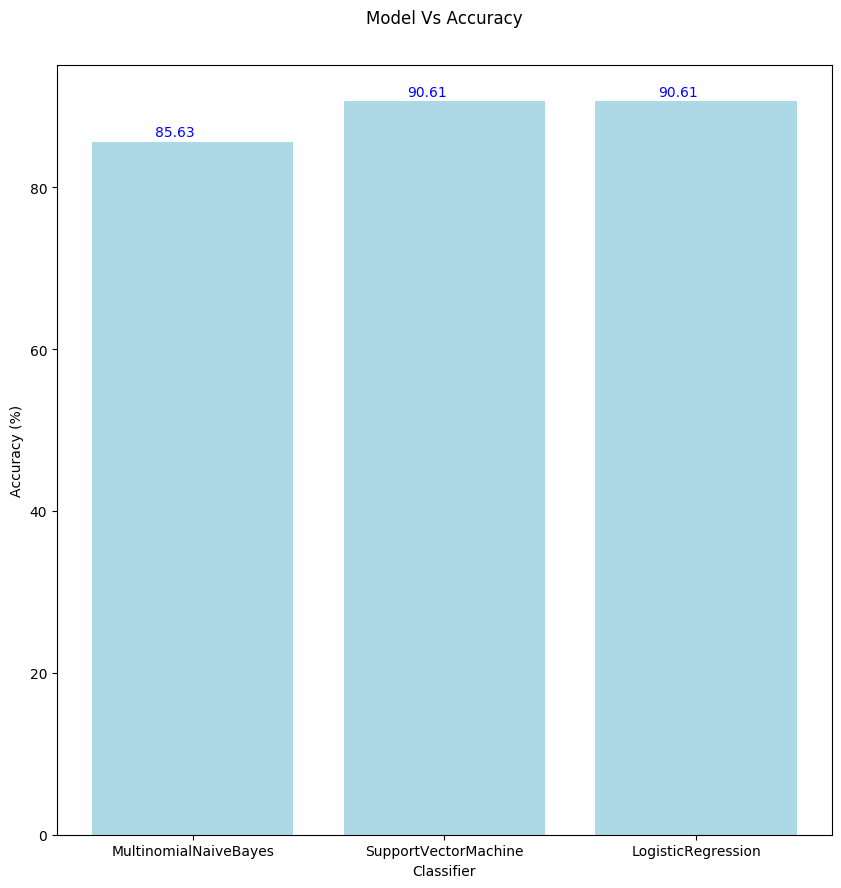

In [144]:
# Metric lists for reference
# model_list = []
# f1_scores = []
# accuracies = []

# Comparison plot for all classifiers with their accuracy
plt.style.use('_classic_test_patch')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
plt.title("Model Vs Accuracy", color='black', pad=30)
plt.xlabel('Classifier', color='black')
plt.ylabel('Accuracy (%)', color='black')
plt.bar(model_list, accuracies, color='lightblue')
for i, j in enumerate(accuracies):
    ax.text(float(i)-0.15, float(j)+0.7, str(j), color='blue')
plt.show()

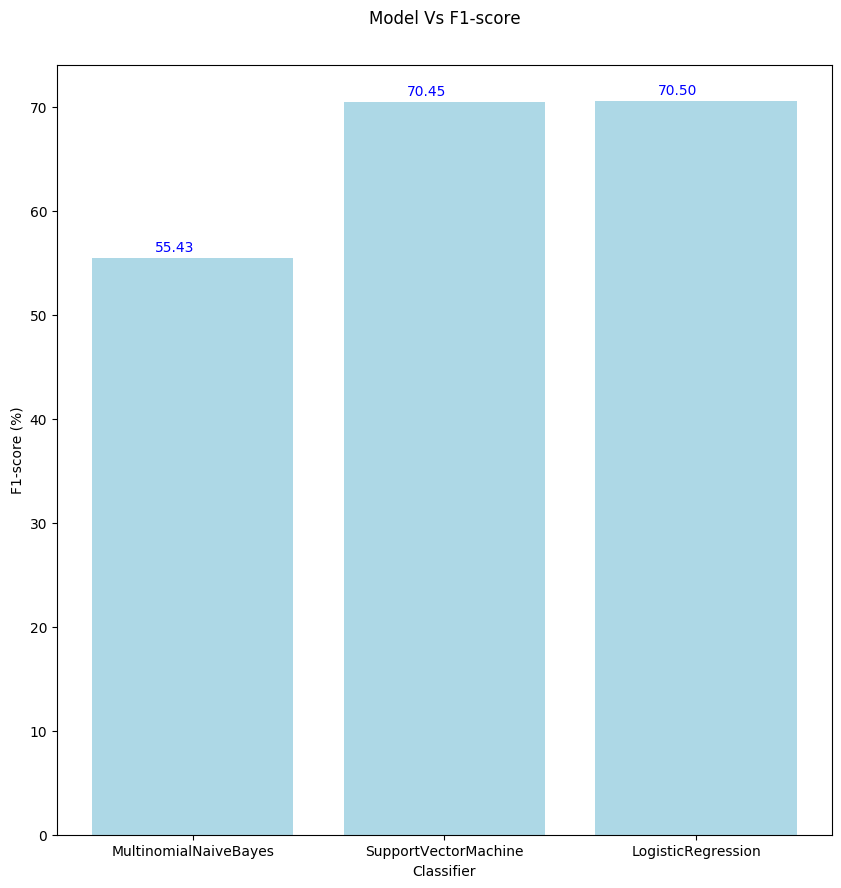

In [145]:
# comparison plot for all classifiers with their F1-score
plt.style.use('_classic_test_patch')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
plt.title("Model Vs F1-score", color='black', pad=30)
plt.xlabel('Classifier', color='black')
plt.ylabel('F1-score (%)', color='black')
plt.bar(model_list, f1_scores, color='lightblue')
for i, j in enumerate(f1_scores):
    ax.text(float(i)-0.15, float(j)+0.7, str(j), color='blue')
plt.show()

# MedicalAnalyzer for Disease Output

This is the main user-model interactive section, all the above code needs to be run so that the following works. This is the minimalist and to the point interaction between user and our model.

### Logistic Regression Model

The best performing model was Logistic Regression, so we'll use that in our evaluations of user input.

This code almost completely adapted from: https://github.com/rahul15197/Disease-Detection-based-on-Symptoms/blob/master/SymptomSuggestion.ipynb


In [81]:
# load the dataset
df_comb = pd.read_csv("Dataset/dis_sym_dataset_comb.csv")
df_norm = pd.read_csv("Dataset/dis_sym_dataset_norm.csv")

# separate the features and labels
X = df_comb.iloc[:, 1:]
Y = df_comb.iloc[:, 0:1]

# convert Y (labels) to a 1D array 
y_array = Y.to_numpy() if isinstance(Y, pd.Series) else Y.values
Y = y_array.ravel()

In [82]:
lr = LogisticRegression()
lr = lr.fit(X, Y)
scores = cross_val_score(lr, X, Y, cv=5)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [83]:
X = df_norm.iloc[:, 1:]
Y = df_norm.iloc[:, 0:1]

In [84]:
# List of symptoms
dataset_symptoms = list(X.columns)

### Input Symptoms --> Disease

This is where we use the model to tell us what diseases the user may have based on the symptoms extracted from their input.

In [114]:
# Create vector from processed user symptoms to be used by the model

# example symptom list
# sym_list = ["yellowish skin","wheezing","abdominal cramp","back","feeling cold"]

def create_symptom_vector(sym_list):
    sym_vector = [0 for i in range(0, len(dataset_symptoms))]
    for sym in sym_list:
        # print(sym)
        sym_vector[dataset_symptoms.index(sym)] = 1
    return sym_vector

In [116]:
# Predict the likelihood for each disease
def predict_diseases(sym_vector):
    disease_predict = lr.predict_proba([sym_vector])
    k = 10
    diseases = list(set(Y['label_dis']))
    diseases.sort()
    top_k = disease_predict[0].argsort()[-k:][::-1]
    return top_k

In [119]:
def output_top_k_diseases(top_k):
    print(f"\nTop {k} diseases predicted based on symptoms")
    topk_dict = {}
    # Show top 10 highly probable disease to the user.
    for idx,t in  enumerate(top_k):
        match_sym=set()
        row = df_norm.loc[df_norm['label_dis'] == diseases[t]].values.tolist()
        row[0].pop(0)
    
        for idx,val in enumerate(row[0]):
            if val!=0:
                match_sym.add(dataset_symptoms[idx])
        prob = (len(match_sym.intersection(set(sym_list)))+1)/(len(set(sym_list))+1)
        prob *= np.mean(scores)
        topk_dict[t] = prob
    j = 0
    topk_index_mapping = {}
    topk_sorted = dict(sorted(topk_dict.items(), key=lambda kv: kv[1], reverse=True))
    for key in topk_sorted:
      prob = topk_sorted[key]*100

      disease_name = f"{diseases[key]:<10}"
      print(str(j+1) + " Disease name:",diseases[key], "\tProbability:",str(round(prob, 2))+"%")
      print(f"{str(j+1)} {disease_name}")
      formatted_string = f"{name:<10}"  # Left-align within 10 characters
      print(f"'{formatted_string}'")

        
      topk_index_mapping[j] = key
      j += 1


## User-interactable Interface

Note: In actual implementation the user wouldn't get the list of diseases shown to them, it would instead be saved to a file and shown to the doctor. This implementation is created to show all of the output in one place to see how the model works.

In [130]:
# Example user input
# user_input = "I have been having migraines and headaches. I can't sleep. My whole body is shaking and shivering. I feel dizzy sometimes. I have a fever."
# new_user_input = normalize_user_input(user_input)
def MedicalAnalyzer():
    new_user_input = user_input()
    print()
    
    # Extract symptoms
    symptoms = extract_symptoms(new_user_input)
    
    # Clean and join the tokens into keywords
    keywords = clean_keywords(symptoms)
    
    # Display the symptoms
    print("Key symptom words: ", keywords)
    print()
    
    # Display all symptoms including synonyms
    synonyms = get_synonyms(keywords)
    final_symptoms = list(synonyms)
    print("Symptoms synonyms list: ", final_symptoms)
    print()
    
    # Get relevant symptoms
    relevant_symptoms = extract_relevant_symptoms(final_symptoms)
    
    print("Final symptoms list: ", relevant_symptoms)
    print()
    
    # Create a vector to be used by the model
    sym_vector = create_symptom_vector(relevant_symptoms)
    
    # Get top diseases
    topk_diseases = predict_diseases(sym_vector)
    
    output_top_k_diseases(topk_diseases)
# Hi doctor, I am a 26 year old male. I am 5 feet and 9 inches tall and weigh 255 pounds. When I eat spicy food, I poop blood. Sometimes when I have constipation as well, I poop a little bit of blood. I am really scared that I have colon cancer. I do have diarrhea often. I do not have a family history of colon cancer. I got blood tests done last night. Please find my reports attached.

In [133]:
MedicalAnalyzer()

Enter symptoms: 


 I'm John, 35 years old, and I've been feeling really off for the past few days. At first, I thought I was just run down from work, but it's getting worse. I feel exhausted all the time, and my whole body aches, especially my back and legs. I thought it might be because I pushed too hard at the gym, but I'm not so sure anymore.  I've also had this headache that won't go away, no matter how much painkiller I take. On top of that, I keep getting these chills, and then I'll suddenly feel really hot. I haven't checked my temperature, though. My throat feels scratchy and sore, and I've been coughing a lot, which is really messing with my sleep.  I'm not hungry at all and feel a bit nauseous, but I haven't thrown up or anything. I haven't been around anyone who's sick, and I haven't traveled recently, so I'm confused about what's going on. I've tried resting and drinking lots of fluids, but nothing seems to help. I'm starting to worry that this might be something serious, so I thought it was


Key symptom words:  ['feeling', 'really', 'off', 'it', 'exhausted', 'aches', 'headache', 'chill', 'hot', 'scratchy', 'sore', 'coughing', 'hungry', 'nauseous', 'thrown', 'up', 'confused', 'back']

Symptoms synonyms list:  ['abrasive', 'raging', 'red-hot', 'hurt', 'baffled', 'play_out', 'afflictive', 'sensitive', 'second', 'bewilder', 'nauseous', 'hurl', 'blur', 'mazed', 'truly', 'yen', 'back', 'vexation', 'cool', 'IT', 'confuse', 'mad', 'fuddle', 'spinal_column', 'rearwards', 'pall', 'up', 'run_down', 'sore', 'discharge', 'yearn', 'improving', 'languish', 'rasping', 'scattered', 'thrill', 'cough', 'tingle', 'spirit', 'turned', 'disordered', 'back_up', 'played_out', 'information_technology', 'gravelly', 'queasy', 'bemused', 'rear', 'loathsome', 'exhaust', 'blistering', 'stake', 'disoriented', 'tire', 'remove', 'obnubilate', 'look', 'cranky', 'disjointed', 'bedevil', 'backrest', 'eject', 'cast', 'suffer', 'genuinely', 'pine', 'sick', 'bet_on', 'confound', 'frisson', 'discombobulate', 'te

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [134]:
dataset_symptoms

['abdominal cramp',
 'abdominal distention',
 'abnormal behavior',
 'abnormal bleeding',
 'abnormal sensation',
 'abnormally frequent',
 'abscess',
 'aching',
 'acne',
 'acquiring drinking alcohol taking lot time',
 'affected part turning white',
 'anemia',
 'anxiety',
 'arm',
 'attack pain',
 'back',
 'bacterial infection',
 'bad breath',
 'bad smelling thin vaginal discharge',
 'bad smelling vaginal discharge',
 'barky cough',
 'belching',
 'better sitting worse lying',
 'birth baby younger week gestational age',
 'bleeding gum',
 'bleeding skin',
 'blindness',
 'blindness one eye',
 'blister sunlight',
 'bloating',
 'blood stool',
 'blood urine',
 'bloody diarrhea',
 'blue',
 'bluish skin coloration',
 'blurred vision',
 'blurry vision',
 'body tremor',
 'bone pain',
 'bowed leg',
 'breakdown skeletal muscle',
 'breathing problem',
 'bruising',
 'burning',
 'burning redness eye',
 'burning stabbing pain',
 'burning urination',
 'certain thought repeatedly',
 'change bowel movement',